In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor() # 데이터를 Tensor 형식으로 변환하기 위함

trainset = torchvision.datasets.MNIST( # torchvision 라이브러리에 내장된 MNIST 데이터셋
    root='./data',
    train=True,
    download=True, # 데이터 없으면 다운로드
    transform=transform # Tensor로 변환
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.42MB/s]


60000
torch.Size([1, 28, 28]) 5


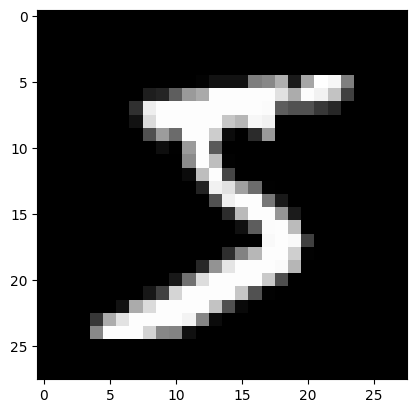

In [3]:
from matplotlib import pyplot as plt


print(len(trainset)) # 학습 데이터셋 크기
print(trainset[0][0].shape, trainset[0][1]) # 첫 번째 샘플 이미지 데이터와 라벨
plt.imshow(trainset[0][0][0], cmap='gray') # 그리기

In [16]:
batch_size = 256 #  한 번에 모델이 학습할 데이터 샘플의 개수 (중요한 hyper param 이라고 했으니 변경 해보기)

# DataLoader : PyTorch에서 데이터셋을 효율적으로 로드하고 배치(batch) 단위로 데이터를 제공하는 역할을 하는 도구
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size, # 미니 배치 크기 설정
    shuffle=True # 데이터 섞어서 배치 설정 ()
)

In [17]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False  # 테스트 데이터는 섞지 않음
)

In [18]:
dataiter = iter(trainloader) # 학습 데이터셋에서 첫 번째 배치를 가져와서 확인
images, labels = next(dataiter)
print(images.shape, labels.shape)
# images는 흑백 이미지로 채널 개수 1. [배치 크기, 채널 수, 이미지 높이, 이미지 너비]
# labels는 64개 이미지에 대한 각각의 정답 라벨

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [19]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim) # 첫 번째 선형 계층 (입력 -> 은닉층)
    self.layer2 = nn.Linear(n_dim, n_dim) # 두 번째 선형 계층 (은닉층 -> 은닉층)
    self.layer3 = nn.Linear(n_dim, 10)  # 세 번째 선형 계층 (은닉층 -> 출력층)

    self.act = nn.ReLU() # 활성화 함수로 ReLU 사용

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # 입력 데이터를 1차원으로 펼침 (28x28 -> 784)
    x = self.act(self.layer1(x))  # 첫 번째 계층 연산 후 ReLU 적용
    x = self.act(self.layer2(x))  # 두 번째 계층 연산 후 ReLU 적용
    x = self.act(self.layer3(x))  # 세 번째 계층 연산 후 ReLU 적용

    return x


model = Model(28 * 28 * 1, 1024) # 모델 생성 (입력 크기: 28x28, 은닉층 크기: 1024)
# 은닉층 크기 = 은닉층 노드의 개수
# 하이퍼파라미터로 2의 제곱수 값이 많이 사용 (GPU 연산 최적화)
# 너무 작으면 학습 부족, 너무 크면 과적합 위험

In [20]:
from torch.optim import SGD

lr = 0.001 # 학습률 (중요한 hyper param)
model = model.to('cuda') # 모델 gpu로 이동

optimizer = SGD(model.parameters(), lr=lr) # batch가 64이므로 사실상 Mini-batch SGD

In [21]:
# 모델의 정확도 계산하는 함수
def accuracy(model, dataloader):
  cnt = 0 # 전체 샘플 수
  acc = 0  # 정확히 맞춘 개수

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs) # 모델 예측값 계산
    preds = torch.argmax(preds, dim=-1) # 가장 높은 값의 인덱스를 예측값으로 설정

    cnt += labels.shape[0] # 전체 샘플 개수 누적
    acc += (labels == preds).sum().item()  # 정확히 맞춘 개수 누적

  return acc / cnt

In [22]:
n_epochs = 100 # 학습 반복 횟수
loss_fn = nn.CrossEntropyLoss() # 손실 함수로 CrossEntropyLoss 사용 (다중 클래스 분류 문제)

# 학습 및 테스트 데이터의 정확도 기록
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad() # 기존 기울기 초기화
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)   # 손실 계산
    loss.backward() # 역전파 수행
    optimizer.step() # 가중치 업데이트

    total_loss += loss.item()  # 손실 값 누적

  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))    #

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 540.6690344810486
Epoch   1 | Loss: 538.747504234314
Epoch   2 | Loss: 536.4109442234039
Epoch   3 | Loss: 533.5473980903625
Epoch   4 | Loss: 530.4849457740784
Epoch   5 | Loss: 527.1917209625244
Epoch   6 | Loss: 523.4950227737427
Epoch   7 | Loss: 519.3059797286987
Epoch   8 | Loss: 514.659255027771
Epoch   9 | Loss: 509.4341561794281
Epoch  10 | Loss: 503.5902667045593
Epoch  11 | Loss: 496.9775197505951
Epoch  12 | Loss: 489.5431571006775
Epoch  13 | Loss: 481.2024402618408
Epoch  14 | Loss: 471.9169797897339
Epoch  15 | Loss: 461.72681617736816
Epoch  16 | Loss: 450.6479676961899
Epoch  17 | Loss: 438.9453225135803
Epoch  18 | Loss: 426.5840827226639
Epoch  19 | Loss: 413.95496129989624
Epoch  20 | Loss: 401.25150191783905
Epoch  21 | Loss: 388.6385246515274
Epoch  22 | Loss: 376.4335843324661
Epoch  23 | Loss: 364.8566290140152
Epoch  24 | Loss: 353.9199171066284
Epoch  25 | Loss: 343.7301368713379
Epoch  26 | Loss: 334.29510283470154
Epoch  27 | Loss: 325.5006

In [23]:
import numpy as np

# 학습 및 테스트 정확도를 시각화하는 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1) # 학습 데이터 정확도 그래프
  plt.plot(x, test_accs, label=label2) # 테스트 데이터 정확도 그래프
  plt.legend()
  plt.show()

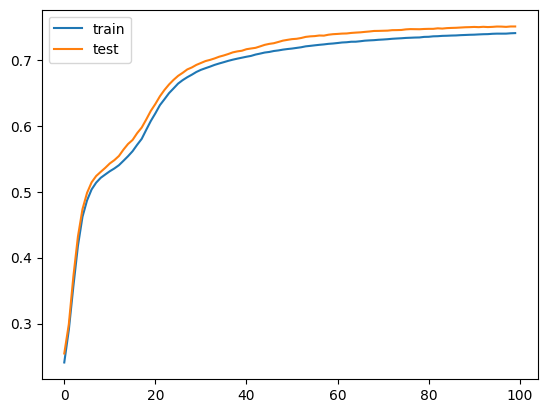

In [24]:
plot_acc(train_accs, test_accs)

In [25]:
idx = 1

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

output = model(x)
predicted_label = torch.argmax(output, dim=1).item()  # 가장 높은 확률의 인덱스 (예측된 숫자)

# 실제 정답 라벨
true_label = trainset[idx][1]

# 출력
print(f"모델 예측값: {predicted_label}")
print(f"실제 정답: {true_label}")
print(f"출력된 확률 분포: {output.softmax(dim=1).cpu().detach().numpy()}")

모델 예측값: 0
실제 정답: 0
출력된 확률 분포: [[9.924349e-01 8.405578e-04 8.405578e-04 8.405578e-04 8.405578e-04
  8.405578e-04 8.405578e-04 8.405578e-04 8.405578e-04 8.405578e-04]]
